<a href="https://colab.research.google.com/github/harshithgowdakc/NYC-Taxi-Data/blob/main/NYC_Taxi_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from haversine import haversine
import statsmodels.formula.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Project CPG/NYC Taxi Data.csv')

In [5]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
data.shape 

(1458644, 11)

In [7]:
#Check count of unique id's in the dataset
print("There are %d unique id's in Training dataset, which is equal to the number of records"%(data.id.nunique()))

There are 1458644 unique id's in Training dataset, which is equal to the number of records


In [8]:
#Check for NaN values
data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [9]:
#Convert timestamp to datetime format to fetch the other details as listed below
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

In [10]:
#Calculate and assign new columns to the dataframe such as weekday,
#month and pickup_hour which will help us to gain more insights from the data.
data['weekday'] = data.pickup_datetime.dt.weekday
data['month'] = data.pickup_datetime.dt.month
data['weekday_num'] = data.pickup_datetime.dt.weekday
data['pickup_hour'] = data.pickup_datetime.dt.hour

In [11]:
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

In [12]:
#Calculate distance and assign new column to the dataframe.
data['distance'] = data.apply(lambda x: calc_distance(x), axis = 1)

In [13]:
#Calculate Speed in km/h for further insights
data['speed'] = (data.distance/(data.trip_duration/3600))

In [14]:
#Check the type of each variable
data.dtypes.reset_index()

,index,0
0,id,object
1,vendor_id,int64
2,pickup_datetime,datetime64[ns]
3,dropoff_datetime,datetime64[ns]
4,passenger_count,int64
5,pickup_longitude,float64
6,pickup_latitude,float64
7,dropoff_longitude,float64
8,dropoff_latitude,float64
9,store_and_fwd_flag,object


In [15]:
#Dummify all the categorical features like "store_and_fwd_flag, vendor_id, month, weekday_num, pickup_hour, passenger_count" except the label i.e. "trip_duration"

dummy = pd.get_dummies(data.store_and_fwd_flag, prefix='flag')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.vendor_id, prefix='vendor_id')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.month, prefix='month')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.weekday_num, prefix='weekday_num')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.pickup_hour, prefix='pickup_hour')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.passenger_count, prefix='passenger_count')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

In [16]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0,1,0,0,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,1,0,0,0,0,0,0,0,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,0,1,0,0,0,0,0,0,0,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,0,1,0,0,0,0,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,0,1,0,0,0,0,0,0,0,0


In [17]:
pd.options.display.float_format = '{:.2f}'.format #To suppres scientific notation.
data.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

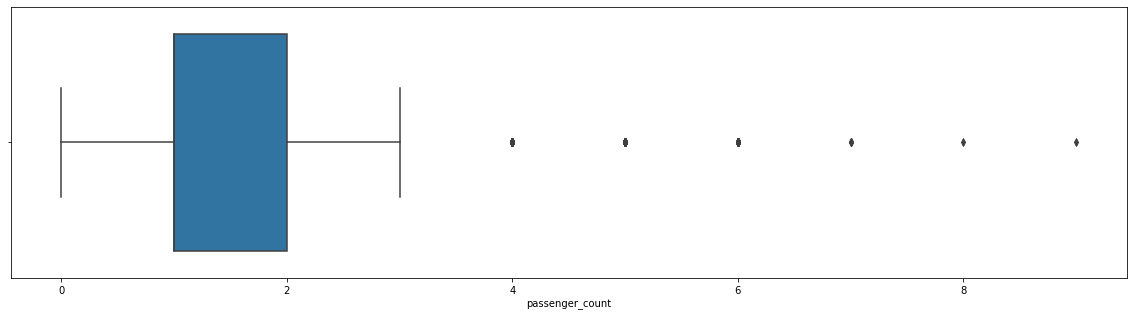

In [18]:
plt.figure(figsize = (20,5))
sns.boxplot(data.passenger_count)
plt.show()

In [19]:
data.passenger_count.describe()

count   1458644.00
mean          1.66
std           1.31
min           0.00
25%           1.00
50%           1.00
75%           2.00
max           9.00
Name: passenger_count, dtype: float64

In [20]:
data['passenger_count'] = data.passenger_count.map(lambda x: 1 if x == 0 else x)

In [21]:
data = data[data.passenger_count <= 6]

In [22]:
data.passenger_count.value_counts()


1    1033600
2     210318
5      78088
3      59896
6      48333
4      28404
Name: passenger_count, dtype: int64

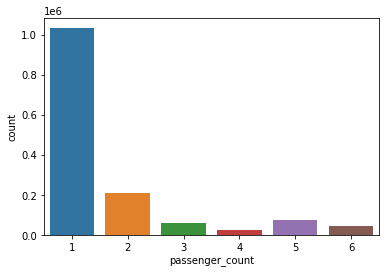

In [23]:
sns.countplot(data.passenger_count)
plt.show()

### Vendor

Here we analyze taxi data only for the 2 vendors which are listed as 1 and 2 in the datset.

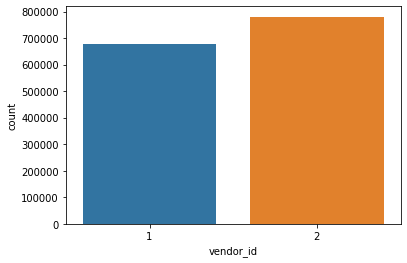

In [24]:
sns.countplot(data.vendor_id)
plt.show()

Though both the vendors seems to have almost equal market share. But Vendor 2 is evidently more famous among the population as per the above graph.

### Distance

Let's now have a look on the distribution of the distance across the different types of rides.


In [25]:
print(data.distance.describe())

count   1458639.00
mean          3.44
std           4.30
min           0.00
25%           1.23
50%           2.09
75%           3.88
max        1240.91
Name: distance, dtype: float64


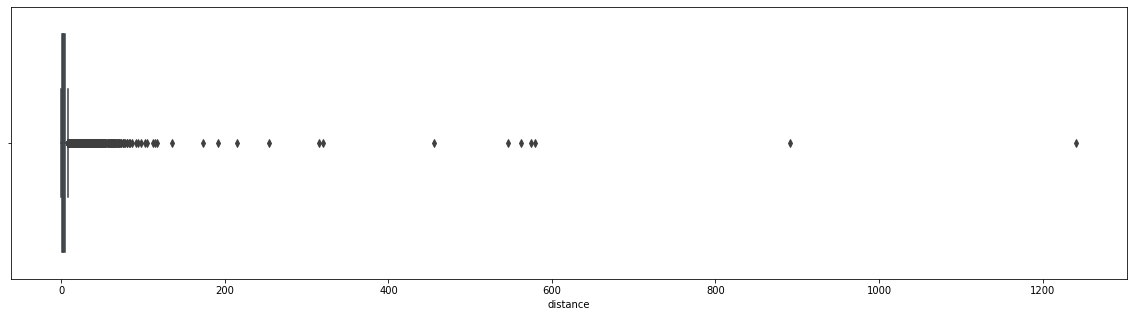

In [26]:
plt.figure(figsize = (20,5))
sns.boxplot(data.distance)
plt.show()

**Interesting find:**
There some trips with over 100 km distance.

Some of the trips distance value is 0 km.

**Observations:**

mean distance travelled is approx 3.5 kms.

standard deviation of 4.3 which shows that most of the trips are limited to the range of 1-10 kms.

In [27]:
print("There are {} trip records with 0 km distance".format(data.distance[data.distance == 0 ].count()))

There are 5895 trip records with 0 km distance


In [28]:
data[data.distance == 0 ].head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
246,id3487442,2,2016-02-29 18:39:12,2016-02-29 18:42:59,1,-73.98,40.77,-73.98,40.77,N,...,0,1,0,0,0,0,0,0,0,0
291,id0924324,2,2016-05-10 18:07:52,2016-05-10 18:26:21,2,-73.96,40.78,-73.96,40.78,N,...,0,0,1,0,0,0,0,0,0,0
407,id1145809,2,2016-05-16 23:15:13,2016-05-16 23:31:00,6,-73.81,40.69,-73.81,40.69,N,...,1,0,0,0,0,0,1,0,0,0
702,id3499387,1,2016-01-25 19:45:12,2016-01-25 19:54:52,1,-73.79,40.65,-73.79,40.65,N,...,0,1,0,0,0,0,0,0,0,0
1620,id0753277,1,2016-01-27 22:29:31,2016-01-27 22:29:58,1,-74.21,40.82,-74.21,40.82,N,...,0,1,0,0,0,0,0,0,0,0


**Observations**

Around 6K trip record with distance equal to 0. Below are some possible explanation for such records.



1.   Customer changed mind and cancelled the journey just after accepting it.
2.   Software didn't recorded dropoff location properly due to which dropoff location is the same as the pickup location.
3.   Issue with GPS tracker while the journey is being finished.
4.   Driver cancelled the trip just after accepting it due to some reason. So the trip couldn't start
5.   Or some other issue with the software itself which a technical guy can explain

There is some serious inconsistencies in the data where drop off location is same as the pickup location. We can't think off imputing the distance values considering a correlation with the duration because the dropoff_location coordinates would not be inline with the distance otherwise. We will look more to it in bivariate analysis with the Trip duration.

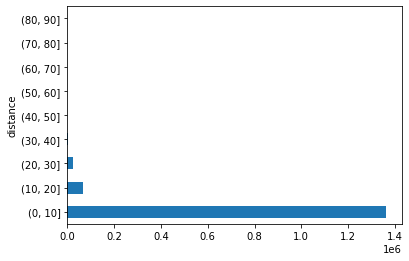

In [29]:
data.distance.groupby(pd.cut(data.distance, np.arange(0,100,10))).count().plot(kind='barh')
plt.show()

From the above observation it is evident that most of the rides are completed between 1-10 Kms with some of the rides with distances between 10-30 kms. Other slabs bar are not visible because the number of trips are very less as compared to these slabs

### Trip duration

In [30]:
data.trip_duration.describe()

count   1458639.00
mean        959.50
std        5237.44
min           1.00
25%         397.00
50%         662.00
75%        1075.00
max     3526282.00
Name: trip_duration, dtype: float64

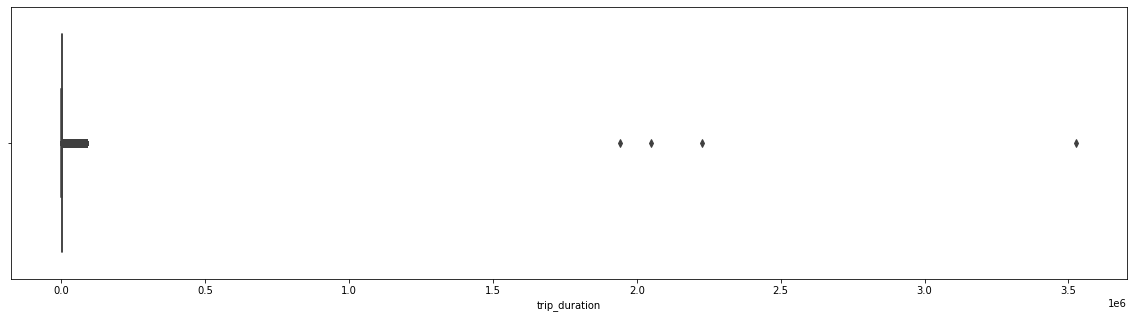

In [31]:
plt.figure(figsize = (20,5))
sns.boxplot(data.trip_duration)
plt.show()

Interesting find:
Some trip durations are over 100000 seconds which are clear outliers and should 
*   Some trip durations are over 100000 seconds which are clear outliers and should be removed.

Observations:

*   There are some durations with as low as 1 second. which points towards trips with 0 km distance.
*   Major trip durations took between 10-20 mins to complete.
*   Mean and mode are not same which shows that trip duration distribution is skewed towards right.

Let's analyze more

In [32]:
data.trip_duration.groupby(pd.cut(data.trip_duration, np.arange(1,max(data.trip_duration),3600))).count()

trip_duration
(1, 3601]             1446308
(3601, 7201]            10045
(7201, 10801]             141
(10801, 14401]             35
(14401, 18001]              5
                       ...   
(3506401, 3510001]          0
(3510001, 3513601]          0
(3513601, 3517201]          0
(3517201, 3520801]          0
(3520801, 3524401]          0
Name: trip_duration, Length: 979, dtype: int64

Observations:

*   There are some trips with more than 24 hours of travel duration i.e. 86400 seconds. Which might have occured on weekends for the outstation travels.
*   Major chunk of trips are completed within an interval of 1 hour with some good numbers of trips duration going above 1 hour.

Let's look at those trips with huge duration, these are outliers and should be removed for the data consistency.

In [33]:
data[data.trip_duration > 86400]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.79,40.64,-73.96,40.77,N,...,0,1,0,0,0,0,0,0,0,0
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.92,40.74,-73.98,40.76,N,...,0,0,1,0,0,0,0,0,0,0
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.98,40.74,-73.99,40.73,N,...,0,1,0,0,0,0,0,0,0,0
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.78,40.65,-73.98,40.75,N,...,0,1,0,0,0,0,0,0,0,0


Observations:

*   These trips ran for more than 20 days, which seems unlikely by the distance travelled.
*   All the trips are taken by vendor 1 which points us to the fact that this vendor might allows much longer trip for outstations.
*   All these trips are either taken on Tuesday's in 1st month or Saturday's in 2nd month. There might be some relation with the weekday, pickup location, month and the passenger.
*   But they fail our purpose of correct prediction and bring inconsistencies in the algorithm calculation.

We should get rid of them for the sake of data consistency. Those are black swans !!

In [34]:
data = data[data.trip_duration <= 86400]

Let's visualize the number of trips taken in slabs of 0-10, 20-30 ... minutes respectively

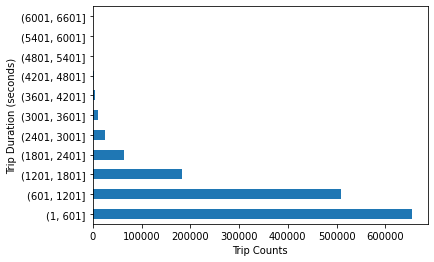

In [35]:
data.trip_duration.groupby(pd.cut(data.trip_duration, np.arange(1,7200,600))).count().plot(kind='barh')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()

We can observe that most of the trips took 0 - 30 mins to complete i.e. approx 1800 secs. Let's move ahead to next feature.

### Speed

Speed is a function of distance and time. Let's visualize speed in different trips.

Maximum speed limit in NYC is as follows:

*   25 mph in urban area i.e. 40 km/h

*   65 mph on controlled state highways i.e. approx 104 km/h
 

In [36]:
data.speed.describe()

count   1458635.00
mean         14.42
std          14.98
min           0.00
25%           9.12
50%          12.79
75%          17.84
max        9274.85
Name: speed, dtype: float64

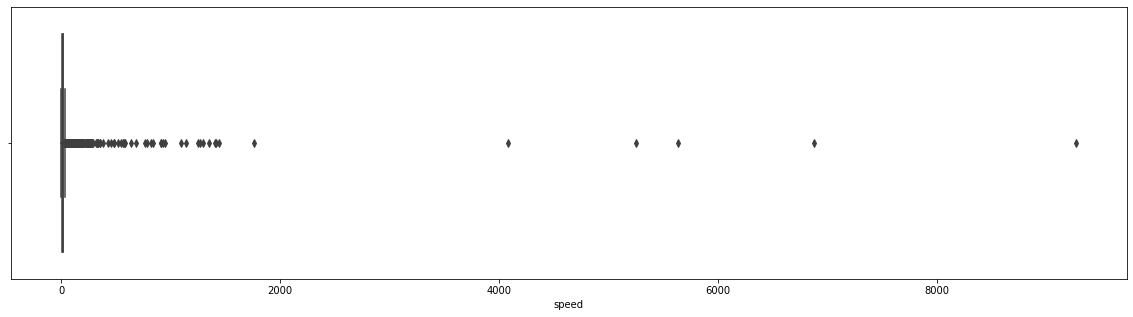

In [37]:
plt.figure(figsize = (20,5))
sns.boxplot(data.speed)
plt.show()

Interesting find:

*   Many trips were done at a speed of over 200 km/h. Going SuperSonic..!!

Let's remove them and focus on the trips which were done at less than 104 km/h as per the speed limits

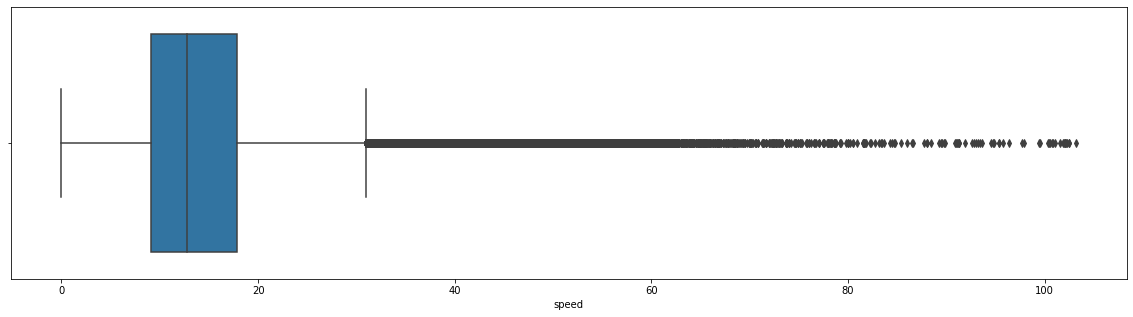

In [38]:
data = data[data.speed <= 104]
plt.figure(figsize = (20,5))
sns.boxplot(data.speed)
plt.show()

Observations:


*   Trips over 30 km/h are being considered as outliers but we cannot ignore them because they are well under the highest speed limit of 104 km/h on state controlled highways.
*   Mostly trips are done at a speed range of 10-20 km/h with an average speed of around 14 km/h.

Let's take a look at the speed range ditribution with the help of graph.

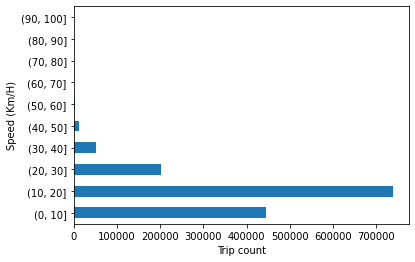

In [39]:
data.speed.groupby(pd.cut(data.speed, np.arange(0,104,10))).count().plot(kind = 'barh')
plt.xlabel('Trip count')
plt.ylabel('Speed (Km/H)')
plt.show()

It is evident from this graph what we thought off earlier i.e. most of the trips were done at a speed range of 10-20 km/H.

### Store_and_fwd_flag

This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip.

In [40]:
data.flag_Y.value_counts(normalize=True)

0   0.99
1   0.01
Name: flag_Y, dtype: float64

Observations:


*   List item


1.   List item

1.   List item
2.   List item


2.   List item


*   List item



In [41]:
data.flag_Y.value_counts()

0    1450433
1       8044
Name: flag_Y, dtype: int64

Above result shows that around 8K trips had to store the flag and then report to the server when the connection was established. Let's check the respective distribution with the vendors for the offline trips.

In [42]:
data.vendor_id[data.flag_Y == 1].value_counts()

1    8044
Name: vendor_id, dtype: int64

Observations:

In [43]:
data[data.flag_Y == 1]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
348,id1633648,1,2016-06-20 14:19:16,2016-06-20 14:34:34,1,-73.98,40.75,-73.95,40.77,Y,...,0,1,0,0,0,0,0,0,0,0
491,id2042535,1,2016-02-12 12:36:38,2016-02-12 12:47:07,1,-73.98,40.76,-73.99,40.75,Y,...,0,1,0,0,0,0,0,0,0,0
610,id0909228,1,2016-05-08 15:02:28,2016-05-08 15:17:54,1,-73.99,40.74,-74.01,40.72,Y,...,0,1,0,0,0,0,0,0,0,0
774,id3697489,1,2016-01-13 13:53:29,2016-01-13 14:08:21,1,-73.95,40.78,-73.98,40.78,Y,...,0,1,0,0,0,0,0,0,0,0
846,id1026973,1,2016-06-25 21:53:30,2016-06-25 22:05:27,1,-73.98,40.76,-74.00,40.75,Y,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457556,id2229555,1,2016-01-22 19:05:50,2016-01-22 19:27:09,1,-73.87,40.77,-73.93,40.73,Y,...,0,1,0,0,0,0,0,0,0,0
1457670,id0510811,1,2016-04-07 21:14:30,2016-04-07 21:51:38,1,-73.78,40.64,-73.98,40.67,Y,...,0,1,0,0,0,0,0,0,0,0
1457897,id3209015,1,2016-03-20 18:49:55,2016-03-20 19:09:25,1,-73.99,40.71,-74.00,40.75,Y,...,0,1,0,0,0,0,0,0,0,0
1458060,id1371896,1,2016-03-28 11:45:49,2016-03-28 12:21:45,1,-73.97,40.76,-74.01,40.72,Y,...,0,1,0,0,0,0,0,0,0,0


Observations



1.   List item

*   List item
*   List item


2.   List item



### Total trips Per Hour

Let's take a look at the distribution of the pickups across the 24 hour time scale.

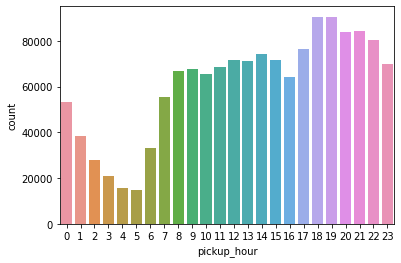

In [44]:
sns.countplot(data.pickup_hour)
plt.show()

Observation

*   It's inline with the general trend of taxi pickups which starts increasing from 6AM in the morning and then declines from late evening i.e. around 8 PM. There is no unusual behavior here.

### Total trips per weekday

Let's take a look now at the distribution of taxi pickups across the week.

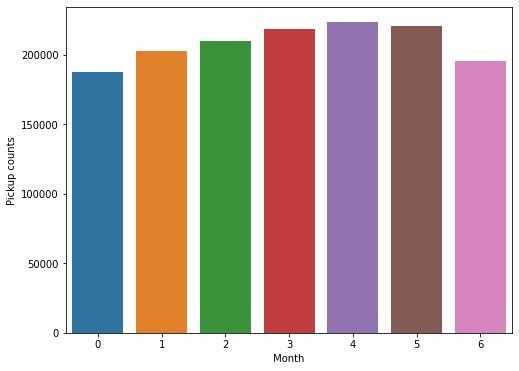

In [45]:
plt.figure(figsize = (8,6))
sns.countplot(data.weekday_num)
plt.xlabel(' Month ')
plt.ylabel('Pickup counts')
plt.show()

Observation
*   Here we can see an increasing trend of taxi pickups starting from Monday till Friday. The trend starts declining from saturday till monday which is normal where some office going people likes to stay at home for rest on the weekends.

Let's drill down more to see the hourwise pickup pattern across the week

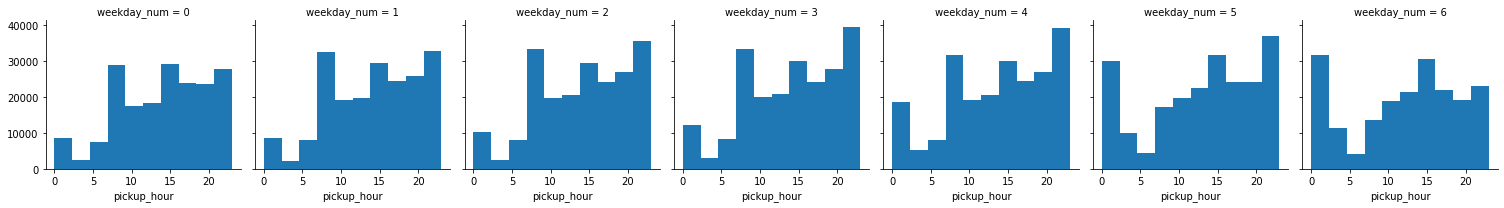

In [46]:
n = sns.FacetGrid(data, col='weekday_num')
n.map(plt.hist, 'pickup_hour')
plt.show()

Interesting find:
*   Taxi pickups increased in the late night hours over the weekend possibly due to more outstation rides or for the late night leisures nearby activities.


*   Early morning pickups i.e before 5 AM have increased over the weekend in comparison to the office hours pickups i.e. after 7 AM which have decreased due to obvious reasons.

*   Taxi pickups seems to be consistent across the week at 15 Hours i.e. at 3 PM.

### Total trips per month

Let's take a look at the trip distribution across the months to understand if there is any diffrence in the taxi pickups in different months

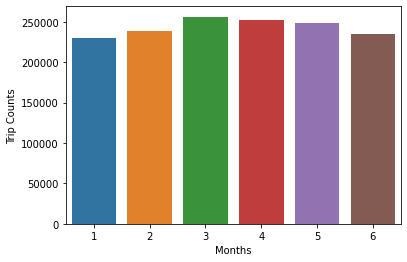

In [47]:
sns.countplot(data.month)
plt.ylabel('Trip Counts')
plt.xlabel('Months')
plt.show()

Quite a balance across the months here. It could have been more equivalent if we wouldn't have removed the inconsistent records in our study of the univariate analysis

## **Bivariate Analysis**

Bivariate analysis is used to find out if there is a relationship between two sets of values. It usually involves the variables X and Y.

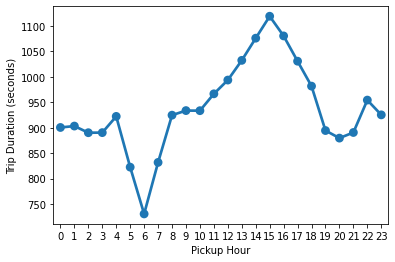

In [48]:
group1 = data.groupby('pickup_hour').trip_duration.mean()
sns.pointplot(group1.index, group1.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Pickup Hour')
plt.show()

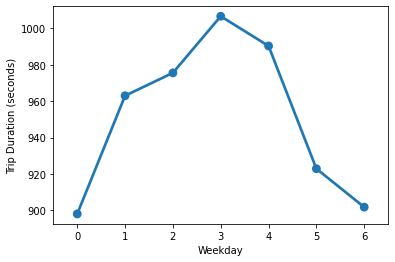

In [49]:
group2 = data.groupby('weekday_num').trip_duration.mean()
sns.pointplot(group2.index, group2.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Weekday')
plt.show()

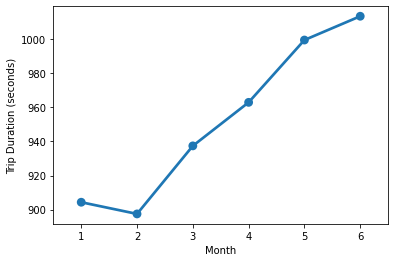

In [50]:
group3 = data.groupby('month').trip_duration.mean()
sns.pointplot(group3.index, group3.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Month')
plt.show()

### Trip duration per vendor

We can also look at the average difference between the trip duration for each vendor. However we do know that vendor 2 has larger share of the market. Let's visualize.

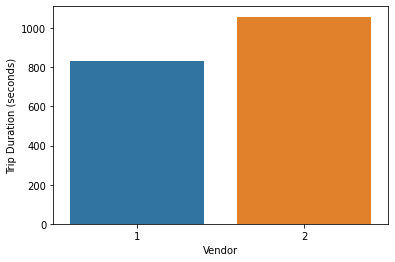

In [51]:
group4 = data.groupby('vendor_id').trip_duration.mean()
sns.barplot(group4.index, group4.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Vendor')
plt.show()

Vendor 2 takes the crown. Average trip duration for vendor 2 is higher than vendor 1 by approx 200 seconds i.e. atleast 3 minutes per trip.

### Trip duration v/s Flag

Let's visualize if there is any effect of flag setting on the trip duration?

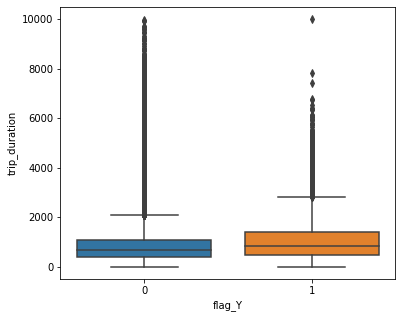

In [52]:
plt.figure(figsize = (6,5))
plot_dur = data.loc[(data.trip_duration < 10000)]
sns.boxplot(x = "flag_Y", y = "trip_duration", data = plot_dur)
plt.show()

Observations:

*   Trip durations scale is less for the trips where the flag is set i.e. the trip details are stored before sending it to the server.
*   Trip duration outliers are also less for the trips with flag 'Y' as compared the trips with flag 'N'.
*   Trip duration is longer for the trips where the flag is not set.
*   Inter quartile range of trip duration is more for the trips with the flag 'Y' as compared to the trips with flag 'N' but the median value is almost equal for both.

### Distance per hour

Now, let us check how the distance is distributed against different variables. We know that trip distance must be more or less proportional to the trip duration if we ignore general traffic and other stuff on the road. Let's visualize this for each hour now.

Since we have already done the outlier analysis for this variable as well. We can take the mean as aggregate measure for our visualizations.

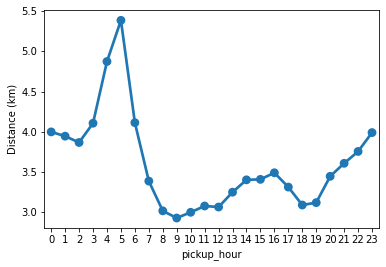

In [53]:
group5 = data.groupby('pickup_hour').distance.mean()
sns.pointplot(group5.index, group5.values)
plt.ylabel('Distance (km)')
plt.show()

Observations:


*   Trip distance is highest during early morning hours which can account for some things like:
    1.   Outstation trips taken during the weekends.

    2.   Longer trips towards the city airport which is located in the outskirts of the city.



*   Trip distance is fairly equal from morning till the evening varying around 3 - 3.5 kms.

*   It starts increasing gradually towards the late night hours starting from evening till 5 AM and decrease steeply towards morning.

In [54]:
pd.set_option('display.max_columns', None)

### Distance per weekday

Let's analyze the average trip distance covered on each day of the week.

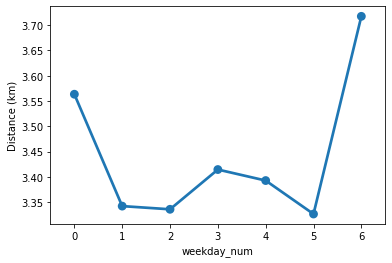

In [55]:
group6 = data.groupby('weekday_num').distance.mean()
sns.pointplot(group6.index, group6.values)
plt.ylabel('Distance (km)')
plt.show()

So it's a fairly equal distribution with average distance metric verying around 3.5 km/h with Sunday being at the top may be due to outstation trips or night trips towards the airport.

### Distance per month

Now we will look at the average trip distance covered per month.

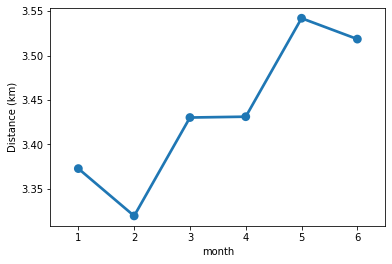

In [56]:
group6 = data.groupby('month').distance.mean()
sns.pointplot(group6.index, group6.values)
plt.ylabel('Distance (km)')
plt.show()

Here also the distibution is almost equivalent, varying mostly around 3.5 km/h with 5th month being the highest in the average distance and 2nd month being the lowest.

Distance per vendor

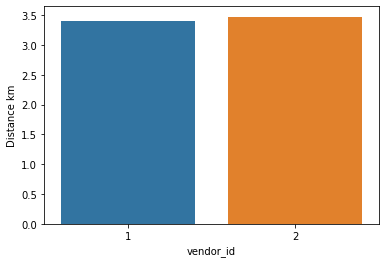

In [57]:
group8 = data.groupby('vendor_id').distance.mean()
sns.barplot(group8.index, group8.values)
plt.ylabel("Distance km")
plt.show()

This is more or less same picture with both the vendors. Nothing more to analyze in this.

### Distance v/s Flag

Let's visualize if there is any effect of Flag setting on the distance covered in the trips

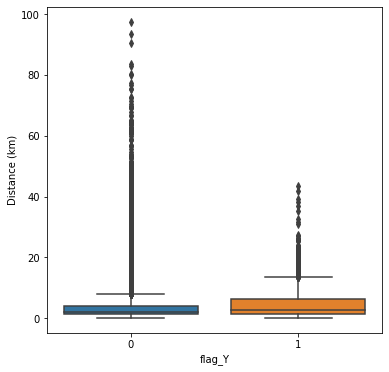

In [58]:
plt.figure(figsize = (6,6))
plot_dist = data.loc[(data.distance < 100)]
sns.boxplot(x = "flag_Y", y = "distance", data = plot_dist)
plt.ylabel('Distance (km)')
plt.show()

Observations:


*   We can see almost similar results like the one observed in the Trip duration v/s Flag analysis.

*   Only two major difference can be seen here.
    1.   Interquartile range of distance is almost twice for Flag 'Y' trips as compared to the Flag 'N' trips

    2.   Median value is much different in both the case as well.

Which points us to the fact that range of distance and trip duration for the Flag 'Y' trips is much more limited and confined as compared with the flag 'N' trips and this also resulted in much less number of outliers for Flag 'Y' trips.

### Distance v/s Trip duration

Let's visualize the relationship between Distance covered and respective trip duration.

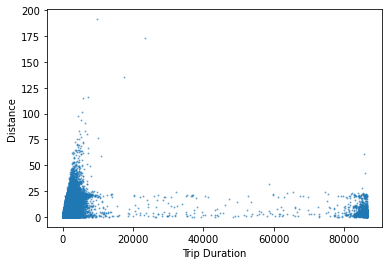

In [59]:
plt.scatter(data.trip_duration, data.distance , s=1, alpha=0.5)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.show()

Interesting find:


*   There are lots of trips which covered negligible distance but clocked more than 20,000 seconds in terms of the Duration.

*   Initially there is some proper correlation between the distance covered and the trip duration in the graph. but later on it all seems uncorrelated.

*   There were few trips which covered huge distance of approx 200 kms within very less time frame, which is unlikely and should be treated as outliers.


Let's focus on the graph area where distance is < 50 km and duration is < 1000 seconds.


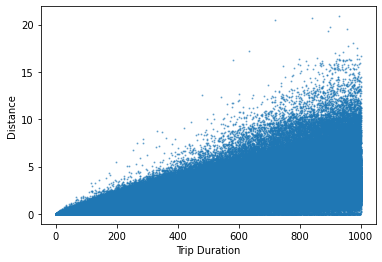

In [60]:
dur_dist = data.loc[(data.distance < 50) & (data.trip_duration < 1000)]
plt.scatter(dur_dist.trip_duration, dur_dist.distance , s=1, alpha=0.5)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.show()

Observations:

*   There should have been a linear relationship between the distance covered and trip duration on an average but we can see dense collection of the trips in the lower right corner which showcase many trips with the inconsistent readings.

Idea:
We should remove those trips which covered 0 km distance but clocked more than 1 minute to make our data more consistent for predictive model. Because if the trip was cancelled after booking, than that should not have taken more than a minute time. This is our assumption.

In [61]:
data = data[~((data.distance == 0) & (data.trip_duration >= 60))]

Now, Instead of looking at each and every trip, we should approximate and try to filter those trips which covered less than 1 km distance and but clocked more than an hour.

In [62]:
duo = data.loc[(data['distance'] <= 1) & (data['trip_duration'] >= 3600),['distance','trip_duration']].reset_index(drop=True)

In [63]:
duo.head(2)

,distance,trip_duration
0,0.03,4107
1,0.77,83016


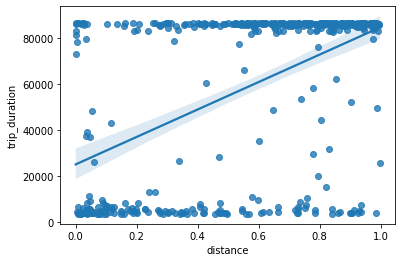

In [64]:
sns.regplot(duo.distance, duo.trip_duration)
plt.show()

Observations:


*   Though the straight line tries to show some linear relation between the two. But there seems to be negligible correlation between these two metric as seen from the scatter plot where it should have been a linear distribution.

*   It is rarely occurs that customer keep sitting in the taxi for more than an hour and it does not travel for even 1 km.

These should be removed to bring in more consistency to our results.

In [65]:
data = data[~((data['distance'] <= 1) & (data['trip_duration'] >= 3600))]

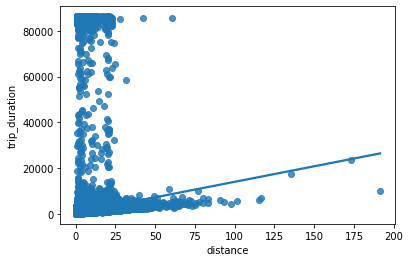

In [66]:
sns.regplot(data.distance, data.trip_duration)
plt.show()

### Average speed per hour

Let's look at the average speed of NYC Taxi per hour.

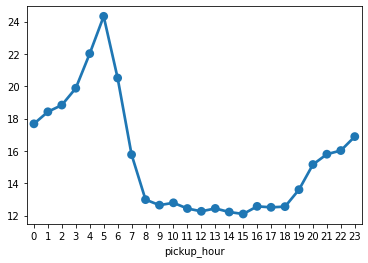

In [67]:
group9 = data.groupby('pickup_hour').speed.mean()
sns.pointplot(group9.index, group9.values)
plt.show()

Observation:

*   The average trend is totally inline with the normal circumstances.
*   Average speed tend to increase after late evening and continues to increase gradually till the late early morning hours.
*   Average taxi speed is highest at 5 AM in the morning, then it declines steeply as the office hours approaches.
*   Average taxi speed is more or less same during the office hours i.e. from 8 AM till 6PM in the evening.

### Average speed per weekday

Let's visualize that on an average what is the speed of a taxi on any given weekday.

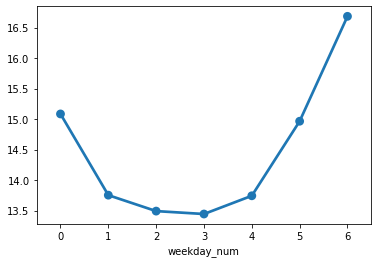

In [68]:
group10 = data.groupby('weekday_num').speed.mean()
sns.pointplot(group10.index, group10.values)
plt.show()

Observations:



*   Average taxi speed is higher on weekend as compared to the weekdays which is obvious when there is mostly rush of office goers and business owners.

*   Even on monday the average taxi speed is shown higher which is quite surprising when it is one of the most busiest day after the weekend. There can be several possibility for such behaviour

    1.   Lot of customers who come back from outstation in early hours of Monday before 6 AM to attend office on time.
    2.   Early morning hours customers who come from the airports after vacation to attend office/business on time for the coming week.

*   There could be some more reasons as well which only a local must be aware of.
*  We also can't deny the anomalies in the dataset. which is quite cumbersome to spot in such a large dataset.

### Passenger count per vendor

Let's try some different metric in the series i.e. passenger count. We will plot it agaist the vendor only because it will not be much helpful to plot it against hour, weekday or month like others as the passenger count should be a whole number and not a ratio.

we will take mean as the aggregate measure because we already did the outlier analysis on this metric. So our results woudn't be affected by some extreme values. Also if we take median than it will return only 1 because majorty of the trips have been taken by single passenger. Let's take a look about it's distribution.

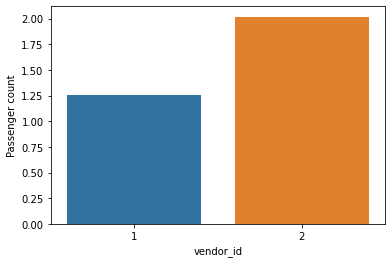

In [69]:
group9 = data.groupby('vendor_id').passenger_count.mean()
sns.barplot(group9.index, group9.values)
plt.ylabel('Passenger count')
plt.show()

Clear difference between the two operators for the average passenger count in all trips. It seems that vendor 2 trips generally consist of 2 passengers as compared to the vendor 1 with 1 passenger. Let's bifurcate it further.

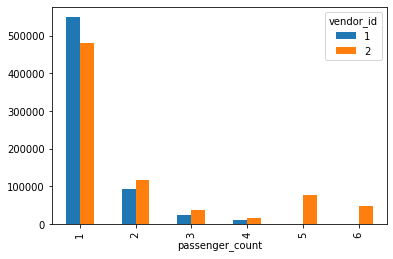

In [70]:
data.groupby('passenger_count').vendor_id.value_counts().reset_index(name='count').pivot("passenger_count","vendor_id","count").plot(kind='bar')
plt.show()

Interesting find:


*   It seems that most of the big cars are served by the Vendor 2 including minivans because other than passenger 1, vendor 2 has majority in serving more than 1 passenger count and that explains it greater share of the market.

# Feature Engineering

After looking at the dataset from different perspectives. Let's prepare our dataset before training our model. Since our dataset do not contain very large number of dimensions. We will first try to use feature selection instead of the feature extraction technique.

Question:
But what's the difference?

Feature selection: we select a subset of the original feature set based on the statistical significance of different parameters.
Example: Backward elimination, Forward selection, Recursive feature elimination

Feature extraction: we build a new set of features from the original feature set
Example: PCA, LDA, Kernel PCA

## Feature Selection

Intuition:

*   We will use backward elimination technique to select the best features to train our model.

*   It displays some statistical metrics with there significance value.

*   Like, It shows the p values for each feature as per its significance in the whole dataset.

*   It also shows the adjusted R squared values to identify whether removing or selecting the feature is beneficial or not.

*   For now we will only look at the P and adjusted R squared value to decide which features to keep and which needed to be removed.

Let's assign the values to X & Y array from the dataset.

In [71]:
#First chech the index of the features and label
list(zip( range(0,len(data.columns)),data.columns))

[(0, 'id'),
 (1, 'vendor_id'),
 (2, 'pickup_datetime'),
 (3, 'dropoff_datetime'),
 (4, 'passenger_count'),
 (5, 'pickup_longitude'),
 (6, 'pickup_latitude'),
 (7, 'dropoff_longitude'),
 (8, 'dropoff_latitude'),
 (9, 'store_and_fwd_flag'),
 (10, 'trip_duration'),
 (11, 'weekday'),
 (12, 'month'),
 (13, 'weekday_num'),
 (14, 'pickup_hour'),
 (15, 'distance'),
 (16, 'speed'),
 (17, 'flag_Y'),
 (18, 'vendor_id_2'),
 (19, 'month_2'),
 (20, 'month_3'),
 (21, 'month_4'),
 (22, 'month_5'),
 (23, 'month_6'),
 (24, 'weekday_num_1'),
 (25, 'weekday_num_2'),
 (26, 'weekday_num_3'),
 (27, 'weekday_num_4'),
 (28, 'weekday_num_5'),
 (29, 'weekday_num_6'),
 (30, 'pickup_hour_1'),
 (31, 'pickup_hour_2'),
 (32, 'pickup_hour_3'),
 (33, 'pickup_hour_4'),
 (34, 'pickup_hour_5'),
 (35, 'pickup_hour_6'),
 (36, 'pickup_hour_7'),
 (37, 'pickup_hour_8'),
 (38, 'pickup_hour_9'),
 (39, 'pickup_hour_10'),
 (40, 'pickup_hour_11'),
 (41, 'pickup_hour_12'),
 (42, 'pickup_hour_13'),
 (43, 'pickup_hour_14'),
 (44, 'pic

In [72]:
Y = data.iloc[:,10].values
X = data.iloc[:,range(15,61)].values

Question:
Why few features are not assigned to the X array like features at the index 2,3,10 were missed?

Idea:

*   duration variable assigned to Y because that is the dependent variable.

*   features such as id, timestamp and weekday were not assigned to X array because they are of type object. And we need an array of float data type.

Trick for backward elimination:
General equation for multiple linear regression is like

Y = a0 + a1x1 + a2x2 + ... + anxn

Since, we dont have x0 in our X array so the regressor won't consider the constant value of the equation i.e. a0. So to make it count in the equation we will append the selected feature set with a contant series of 1's as a first column. To make it appear like below equation to the statsmodel.

y = a0x0 + a1x1 + a2x2 + ... + anxn

In [73]:
print("Let's append {} rows of 1's as the first column in the X array".format(X.shape[0]))

Let's append 1453811 rows of 1's as the first column in the X array


In [74]:
X1 = np.append(arr = np.ones((X.shape[0],1)).astype(int), values = X, axis = 1)

In [75]:
X1.shape

(1453811, 47)

There we go, our feature set is now ready for the feature selection model with 1s in the first column for a0 constant.

Let's fit stats model on the X array to figure out an optimal set of features by recursively checking for the highest p value and removing the feature of that index.

Note:
Here we will take the level of significance as 0.05 i.e. 5% which means that we will reject feature from the list of array and re-run the model till p value for all the features goes below .05 to find out the optimal combination for our model.

In [76]:
import statsmodels.api as sm

In [77]:
#Select all the features in X array
X_opt = X1[:,range(0,46)]
regressor_OLS = sm.OLS(endog = Y, exog = X_opt).fit()

#Fetch p values for each feature
p_Vals = regressor_OLS.pvalues

#define significance level for accepting the feature.
sig_Level = 0.05

#Loop to iterate over features and remove the feature with p value less than the sig_level
while max(p_Vals) > sig_Level:
    print("Probability values of each feature \n")
    print(p_Vals)
    X_opt = np.delete(X_opt, np.argmax(p_Vals), axis = 1)
    print("\n")
    print("Feature at index {} is removed \n".format(str(np.argmax(p_Vals))))
    print(str(X_opt.shape[1]-1) + " dimensions remaining now... \n")
    regressor_OLS = sm.OLS(endog = Y, exog = X_opt).fit()
    p_Vals = regressor_OLS.pvalues
    print("=================================================================\n")
    
#Print final summary
print("Final stat summary with optimal {} features".format(str(X_opt.shape[1]-1)))
regressor_OLS.summary()

Probability values of each feature 

[1.25386827e-001 0.00000000e+000 0.00000000e+000 5.69457963e-001
 1.93864427e-305 2.61478046e-001 3.80040007e-001 7.81240873e-001
 1.08697373e-001 3.30535697e-002 4.64189813e-001 8.08673416e-002
 3.44790983e-001 8.44025519e-001 2.41857880e-005 1.87745922e-018
 2.09147233e-003 7.20820544e-008 1.46505352e-011 7.60942585e-016
 3.14733659e-016 2.11002692e-005 1.71387106e-004 5.78421965e-017
 1.57431960e-017 4.41736293e-020 5.75605739e-026 3.87928788e-020
 3.24848486e-019 4.28545912e-022 2.52594424e-016 2.54189055e-016
 6.37167155e-021 2.74737033e-021 4.16080946e-022 3.13870281e-010
 1.25082621e-004 3.19101002e-001 6.38999031e-002 3.12075069e-002
 3.51650053e-002 3.12977172e-002 2.99087252e-002 2.98881254e-002
 2.95806415e-002             nan]


Feature at index 45 is removed 

44 dimensions remaining now... 


Probability values of each feature 

[1.25386827e-001 0.00000000e+000 0.00000000e+000 5.69457963e-001
 1.93864427e-305 2.61478046e-001 3.80040007

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.153
Model:                            OLS   Adj. R-squared (uncentered):              0.153
Method:                 Least Squares   F-statistic:                              7745.
Date:                Fri, 10 Mar 2023   Prob (F-statistic):                        0.00
Time:                        07:21:22   Log-Likelihood:                     -1.3623e+07
No. Observations:             1453811   AIC:                                  2.725e+07
Df Residuals:                 1453777   BIC:                                  2.725e+07
Df Model:                          34                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           228.6199      0.726    314.845      0.000     227.197     230.043
x2           -87.4717      0.394   -222.050      0.000     -88.244     -86.700
x3           185.7224      4.948     37.531      0.000     176.024     195.421
x4            14.3769      6.398      2.247      0.025       1.836      26.918
x5            18.4692      6.553      2.819      0.005       5.626      31.312
x6            44.8044      6.758      6.629      0.000      31.558      58.051
x7            88.8915      7.190     12.364      0.000      74.800     102.983
x8            75.6033     15.858      4.768      0.000      44.522     106.684
x9           130.0909     18.213      7.143      0.000      94.393     165.789
x10          173.9868     20.754      8.383      0.000     133.310     214.664
x11          225.1705     23.584      9.548      0.000     178.947     271.394
x12          232.6885     24.190      9.619      0.000     185.278     280.099
x13          101.8353     16.923      6.017      0.000      68.666     135.004
x14          -48.4034     13.662     -3.543      0.000     -75.180     -21.627
x15         -122.5362     12.760     -9.603      0.000    -147.545     -97.527
x16         -124.6332     12.709     -9.806      0.000    -149.543     -99.723
x17         -136.4258     12.857    -10.611      0.000    -161.625    -111.226
x18         -157.5283     12.658    -12.445      0.000    -182.337    -132.719
x19         -133.6872     12.441    -10.746      0.000    -158.071    -109.303
x20         -130.0589     12.463    -10.436      0.000    -154.486    -105.632
x21         -140.3987     12.304    -11.411      0.000    -164.514    -116.284
x22         -117.4328     12.462     -9.423      0.000    -141.859     -93.007
x23         -120.4578     12.961     -9.294      0.000    -145.861     -95.054
x24         -134.7737     12.158    -11.086      0.000    -158.602    -110.945
x25         -131.2997     11.452    -11.465      0.000    -153.745    -108.854
x26         -134.1589     11.423    -11.744      0.000    -156.549    -111.769
x27          -82.6733     11.679     -7.079      0.000    -105.564     -59.783
x28          -43.8670     11.667     -3.760      0.000     -66.733     -21.001
x29         1362.0413      9.098    149.709      0.000    1344.210    1379.873
x30         1344.1856     10.670    125.977      0.000    1323.273    1365.099
x31         1362.1032     14.564     93.523      0.000    1333.558    1390.649
x32         1369.4187     18.980     72.151      0.000    1332.219    1406.619
x33         1368.7505     14.031     97.549      0.000    1341.249    1396.252
x34         1370.4601     16.195     84.623      0.000    1338.719    1402.202
=============================================================

Observations
Finally we have reached the combination of optimum features with each feature having p value < 0.05.

### **Split Data**

Before training our model on the dataset, we need to split the dataset into training and testing datasets. This is required to train our model on the major part of our dataset and test the accuracy of the model on the minor part. Let's split it

In [78]:
#Split raw data
X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state=4, test_size=0.2)

#Split data from the feature selection group
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_opt,Y, random_state=4, test_size=0.2)

This will divide our dataset randomly with a ratio of 80/20 where training set consists of more than 1 million records and test dataset with more than .35 million records. Let's train our model on the training set now.

## **Feature Extraction**

We will use PCA for feature extraction i.e. Principal Component Analysis. It is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components

Split Data
Lets split our data first before scaling the features

In [79]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X,Y, random_state=4, test_size=0.2)

Scale Data


It is suggested to scale the input varibles first before applying PCA to standardise the variance and avoid the bias. Lets Scale the data using StandardScaler.

In [80]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)

**PCA application**

Let's apply PCA technique on the training features to understand how many principal components should we select for our model to capture atleast 90% variance. For that we will take help of plot and cumsum function of numpy package.

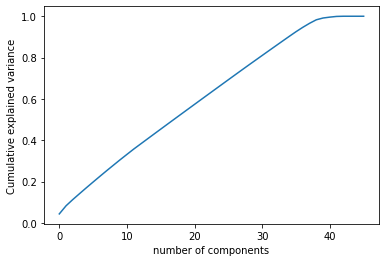

In [81]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train_pca)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [82]:
arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
list(zip(range(1,len(arr)), arr))

[(1, 4.32),
 (2, 8.26),
 (3, 11.29),
 (4, 14.149999999999999),
 (5, 16.979999999999997),
 (6, 19.759999999999998),
 (7, 22.509999999999998),
 (8, 25.229999999999997),
 (9, 27.9),
 (10, 30.56),
 (11, 33.14),
 (12, 35.71),
 (13, 38.13),
 (14, 40.550000000000004),
 (15, 42.970000000000006),
 (16, 45.38000000000001),
 (17, 47.790000000000006),
 (18, 50.190000000000005),
 (19, 52.59),
 (20, 54.980000000000004),
 (21, 57.370000000000005),
 (22, 59.760000000000005),
 (23, 62.14000000000001),
 (24, 64.52000000000001),
 (25, 66.9),
 (26, 69.28),
 (27, 71.65),
 (28, 74.02000000000001),
 (29, 76.37),
 (30, 78.7),
 (31, 81.03),
 (32, 83.35),
 (33, 85.66),
 (34, 87.97),
 (35, 90.27),
 (36, 92.53),
 (37, 94.64),
 (38, 96.58),
 (39, 98.28999999999999),
 (40, 99.14999999999999),
 (41, 99.58),
 (42, 99.92),
 (43, 100.01),
 (44, 100.01),
 (45, 100.01)]

Observation

*   Here we can see that almost 40 variables are needed for capturing atleast 99% of the variance in the training dataset. Hence we will use the same set of variables.

In [83]:
pca_10 = PCA(n_components=40)
X_train_pca = pca_10.fit_transform(X_train_pca)
X_test_pca = pca_10.transform(X_test_pca)

PCA is applied on the training and the test dataset. Our input features are now ready for the regression.

Correlation Analysis

Correlation analysis is a method of statistical evaluation used to study the strength of a relationship between two or more, numerically measured, continuous variables. This analysis is useful when we need to check if there are possible connections between variables. We will utilize Heatmap for our analysis.

Heatmap

A heatmap is a graphical representation of data that uses a system of color-coding to represent statistical relationship between different values.

Let's plot the relationship between the features of the Feature selection group first

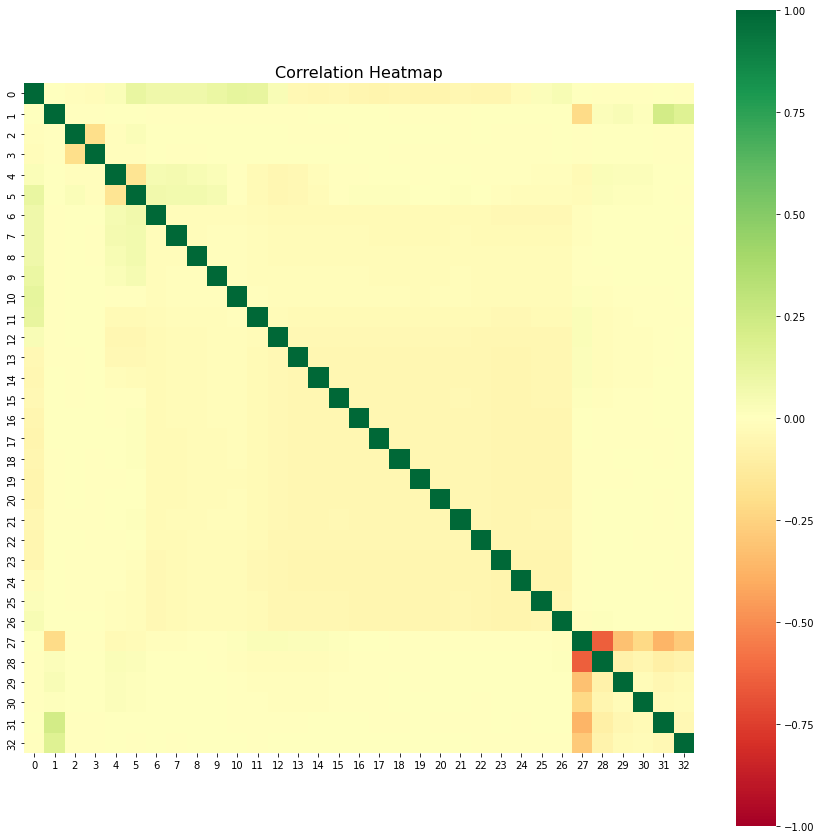

In [84]:
plt.figure(figsize=(15,15))
corr = pd.DataFrame(X_train_fs[:,1:]).corr()
corr.index = pd.DataFrame(X_train_fs[:,1:]).columns
sns.heatmap(corr, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

Observations


*   Some combinations of features shows slight correlation but not above 0.5.


*   Some features are infact negatively correlated.

*   But most of the features shows no correlation. Which is a good thing.


All in all, we have a very good pack of attributes to train our model. Let's move ahead.

Let's now plot the relationship between the features of the Feature extraction group.